In [1]:
%pylab inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

# from tqdm import trange, tqdm
from functools import partial
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)
trange = partial(trange, position=0, leave=True)


Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Fri Jun 24 17:12:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
DEVICE='cuda:0'

In [5]:
BATCH=32

In [6]:
train_data = datasets.MNIST(
	root='data',
	train=True,
	transform=transforms.Compose([
		ToTensor(),
		# Grayscale(1),
		transforms.Normalize((0.5), (0.5))
	]),
	download=True,
);

trainloader = torch.utils.data.DataLoader(
	train_data,
	batch_size=BATCH,
	num_workers=12,
	shuffle=True
)
print(len(trainloader))

1875


torch.Size([1, 28, 28])


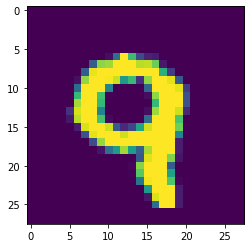

In [7]:
for i, data in enumerate(trainloader):
	if i == 10:
		print(data[0][0].shape)
		imshow(data[0][0].reshape(28,28).numpy())
		break

In [8]:
class G(nn.Module):
	def __init__(self):
		super(G, self).__init__()

		self.deconvs = nn.Sequential(
			nn.ConvTranspose2d(1, 64, 5),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(),

			nn.ConvTranspose2d(64, 128, 5),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(),

			nn.ConvTranspose2d(128, 256, 5),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(),

			nn.ConvTranspose2d(256, 1, 5),
			nn.Tanh()
		)

	def forward(self, x):
		x = self.deconvs(x)

		return x

noise shape: torch.Size([32, 1, 20, 20])
out shape: torch.Size([32, 1, 36, 36])
out 0 shape: torch.Size([1, 36, 36])


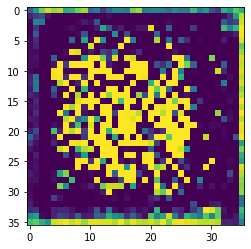

In [9]:
t_generator = G().to(DEVICE)

t_noise = torch.randn(BATCH, 1, 20, 20).to(DEVICE)
print('noise shape:', t_noise.shape)

t_out = t_generator(t_noise)

print('out shape:', t_out.shape)
print('out 0 shape:', t_out[0].shape)

imshow(t_out[0].reshape(t_out.shape[2], t_out.shape[3]).cpu().detach())

In [10]:
class D(nn.Module):
	def __init__(self):
		super(D, self).__init__()

		self.convs = nn.Sequential(
			nn.Conv2d(1, 64, 5),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(),

			nn.Conv2d(64, 128, 5),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(),

			nn.Conv2d(128, 256, 5),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(),
		)

		self.classifier = nn.Sequential(nn.Linear(256 * 16 * 16, 1), nn.Sigmoid())

	def forward(self, x):
		x = self.convs(x)
		x = x.reshape(x.shape[0], -1)
		x = self.classifier(x)

		return x

In [11]:
generator = G().to(DEVICE)
discriminator = D().to(DEVICE)

In [12]:
bce = nn.BCELoss().to(DEVICE)

g_optim = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999)) # 3e-4
d_optim = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999)) # 1e-5

EPOCHS = 2

d_losses = []
g_losses = []

In [13]:
def test_render(g):
  n1 = torch.randn(BATCH, 1, 20, 20).to(DEVICE)
  out = g(n1)
  return out[0].reshape(out.shape[2], out.shape[3]).cpu().detach()

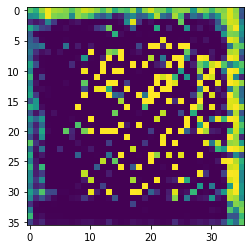

In [14]:
imshow(test_render(generator))

0it [00:00, ?it/s]

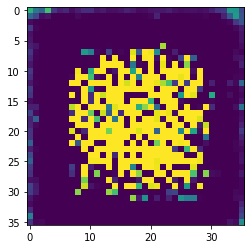

3it [00:00,  8.04it/s]


 EPOCH 0 iter 0 
 g_loss 0.3116801977157593 
 d_loss 1.7697832584381104 



49it [00:02, 21.62it/s]

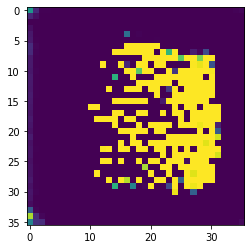

55it [00:03, 16.69it/s]


 EPOCH 0 iter 50 
 g_loss 4.227072715759277 
 d_loss 0.07951410114765167 



100it [00:05, 21.68it/s]

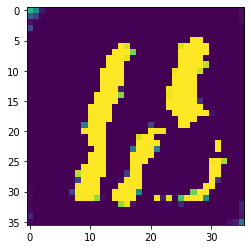

103it [00:05, 17.38it/s]


 EPOCH 0 iter 100 
 g_loss 4.320286273956299 
 d_loss 0.6609997749328613 



148it [00:07, 21.74it/s]

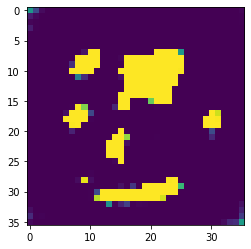

154it [00:07, 18.40it/s]


 EPOCH 0 iter 150 
 g_loss 4.214372634887695 
 d_loss 0.06661692261695862 



199it [00:09, 21.72it/s]

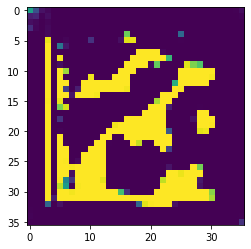

205it [00:10, 18.38it/s]


 EPOCH 0 iter 200 
 g_loss 4.852184295654297 
 d_loss 0.021966010332107544 



250it [00:12, 21.75it/s]

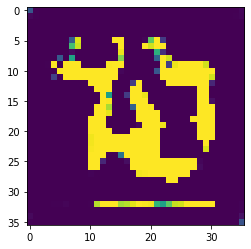

253it [00:12, 17.30it/s]


 EPOCH 0 iter 250 
 g_loss 4.670582294464111 
 d_loss 0.18867552280426025 



298it [00:14, 21.62it/s]

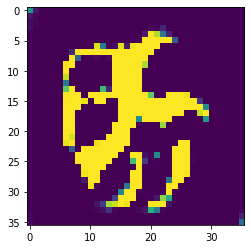

304it [00:15, 18.53it/s]


 EPOCH 0 iter 300 
 g_loss 3.906367301940918 
 d_loss 0.09838272631168365 



349it [00:17, 21.63it/s]

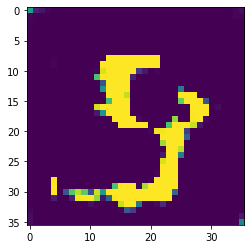

355it [00:17, 18.35it/s]


 EPOCH 0 iter 350 
 g_loss 5.254849433898926 
 d_loss 0.03857674077153206 



400it [00:19, 21.60it/s]

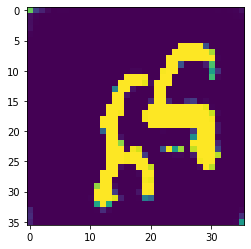

403it [00:19, 17.25it/s]


 EPOCH 0 iter 400 
 g_loss 4.836233139038086 
 d_loss 0.030143046751618385 



448it [00:22, 21.75it/s]

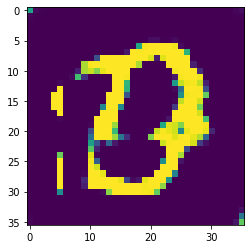

454it [00:22, 18.31it/s]


 EPOCH 0 iter 450 
 g_loss 7.759197235107422 
 d_loss 0.07853514701128006 



499it [00:24, 21.54it/s]

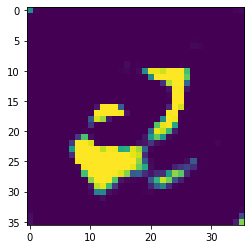

505it [00:24, 18.30it/s]


 EPOCH 0 iter 500 
 g_loss 5.260251045227051 
 d_loss 0.05311375856399536 



550it [00:26, 21.63it/s]

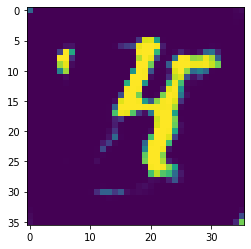

553it [00:27, 17.18it/s]


 EPOCH 0 iter 550 
 g_loss 5.49846076965332 
 d_loss 0.45954176783561707 



598it [00:29, 21.50it/s]

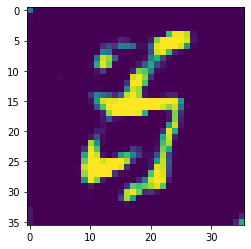

604it [00:29, 18.18it/s]


 EPOCH 0 iter 600 
 g_loss 5.08232307434082 
 d_loss 0.12957562506198883 



649it [00:31, 21.64it/s]

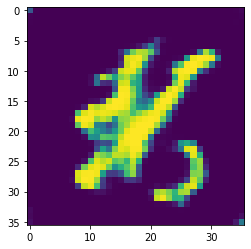

655it [00:32, 18.41it/s]


 EPOCH 0 iter 650 
 g_loss 4.23573637008667 
 d_loss 0.1040152907371521 



700it [00:34, 21.47it/s]

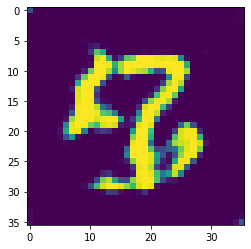

703it [00:34, 14.96it/s]


 EPOCH 0 iter 700 
 g_loss 3.9128198623657227 
 d_loss 0.17588381469249725 



748it [00:36, 21.38it/s]

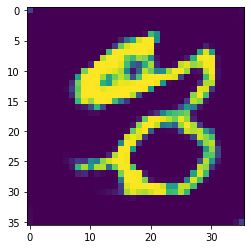

754it [00:37, 18.29it/s]


 EPOCH 0 iter 750 
 g_loss 5.107169151306152 
 d_loss 0.24786964058876038 



799it [00:39, 21.44it/s]

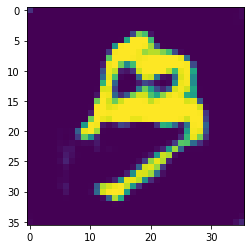

805it [00:39, 18.25it/s]


 EPOCH 0 iter 800 
 g_loss 3.045725107192993 
 d_loss 1.1857515573501587 



850it [00:41, 21.39it/s]

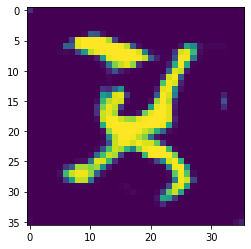

853it [00:41, 17.15it/s]


 EPOCH 0 iter 850 
 g_loss 6.0862908363342285 
 d_loss 0.0746469497680664 



900it [00:44, 20.46it/s]

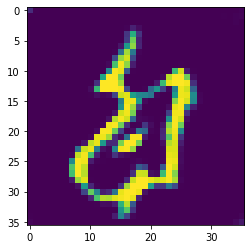

903it [00:44, 16.37it/s]


 EPOCH 0 iter 900 
 g_loss 4.653653621673584 
 d_loss 0.15430699288845062 



948it [00:46, 21.38it/s]

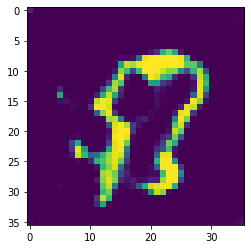

954it [00:47, 18.27it/s]


 EPOCH 0 iter 950 
 g_loss 6.203051567077637 
 d_loss 0.020912310108542442 



999it [00:49, 21.45it/s]

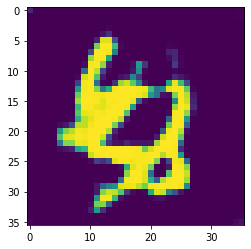

1005it [00:49, 18.27it/s]


 EPOCH 0 iter 1000 
 g_loss 5.788689613342285 
 d_loss 0.1290605366230011 



1050it [00:51, 21.31it/s]

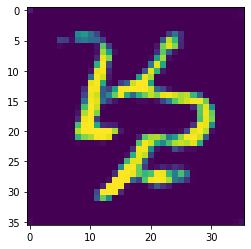

1053it [00:51, 17.03it/s]


 EPOCH 0 iter 1050 
 g_loss 4.2661542892456055 
 d_loss 0.017613105475902557 



1098it [00:54, 21.33it/s]

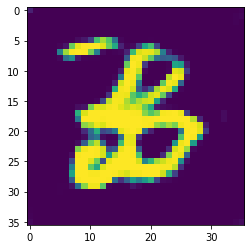

1104it [00:54, 17.72it/s]


 EPOCH 0 iter 1100 
 g_loss 4.951671600341797 
 d_loss 0.0821162760257721 



1149it [00:56, 21.41it/s]

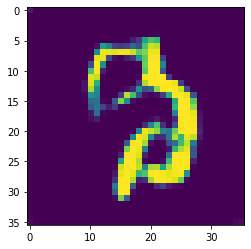

1155it [00:56, 18.08it/s]


 EPOCH 0 iter 1150 
 g_loss 3.7165918350219727 
 d_loss 0.10705610364675522 



1200it [00:59, 21.43it/s]

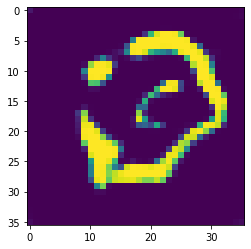

1203it [00:59, 17.06it/s]


 EPOCH 0 iter 1200 
 g_loss 3.9993762969970703 
 d_loss 0.07149987667798996 



1248it [01:01, 21.31it/s]

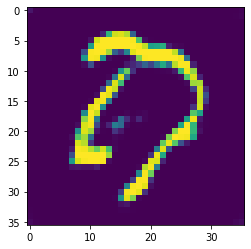

1254it [01:01, 18.10it/s]


 EPOCH 0 iter 1250 
 g_loss 4.263602256774902 
 d_loss 0.25303012132644653 



1299it [01:03, 21.36it/s]

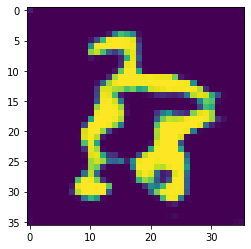

1305it [01:04, 18.28it/s]


 EPOCH 0 iter 1300 
 g_loss 5.094756126403809 
 d_loss 0.03245428949594498 



1350it [01:06, 21.43it/s]

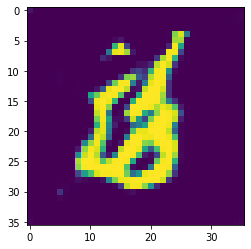

1353it [01:06, 15.20it/s]


 EPOCH 0 iter 1350 
 g_loss 7.395669460296631 
 d_loss 0.05387977138161659 



1398it [01:08, 21.30it/s]

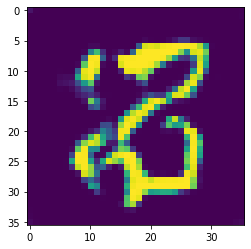

1404it [01:09, 18.22it/s]


 EPOCH 0 iter 1400 
 g_loss 6.972278118133545 
 d_loss 0.015860874205827713 



1449it [01:11, 21.33it/s]

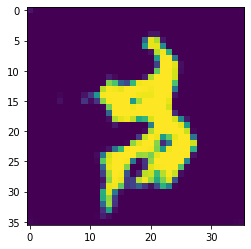

1455it [01:11, 18.12it/s]


 EPOCH 0 iter 1450 
 g_loss 6.107931137084961 
 d_loss 0.043492503464221954 



1500it [01:13, 21.08it/s]

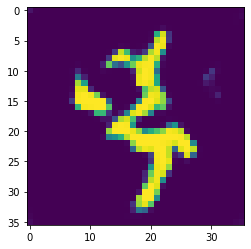

1503it [01:14, 16.72it/s]


 EPOCH 0 iter 1500 
 g_loss 6.688249588012695 
 d_loss 0.056195467710494995 



1548it [01:16, 21.42it/s]

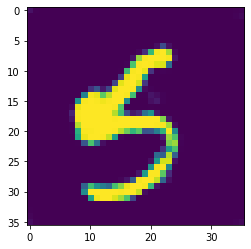

1554it [01:16, 18.16it/s]


 EPOCH 0 iter 1550 
 g_loss 4.481766700744629 
 d_loss 0.08011017739772797 



1599it [01:18, 21.19it/s]

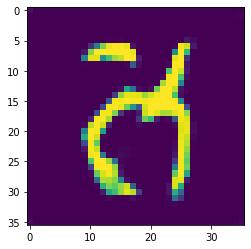

1605it [01:19, 18.07it/s]


 EPOCH 0 iter 1600 
 g_loss 6.660797119140625 
 d_loss 0.030641067773103714 



1650it [01:21, 21.19it/s]

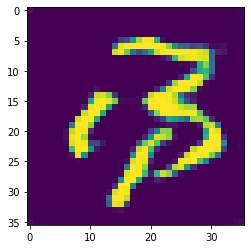

1653it [01:21, 17.00it/s]


 EPOCH 0 iter 1650 
 g_loss 7.097143173217773 
 d_loss 0.08878088742494583 



1698it [01:23, 21.37it/s]

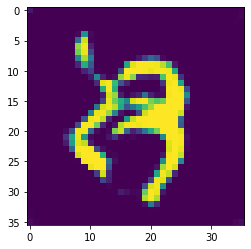

1704it [01:24, 18.27it/s]


 EPOCH 0 iter 1700 
 g_loss 6.599588394165039 
 d_loss 0.02122175134718418 



1749it [01:26, 21.35it/s]

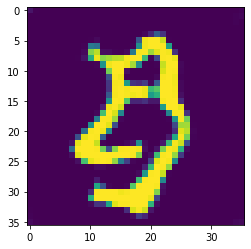

1755it [01:26, 18.29it/s]


 EPOCH 0 iter 1750 
 g_loss 3.6508877277374268 
 d_loss 0.1768372803926468 



1800it [01:28, 21.38it/s]

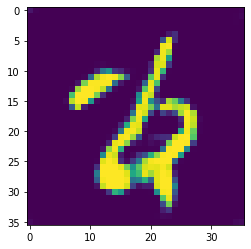

1803it [01:28, 17.08it/s]


 EPOCH 0 iter 1800 
 g_loss 6.4750823974609375 
 d_loss 0.039817821234464645 



1848it [01:31, 21.31it/s]

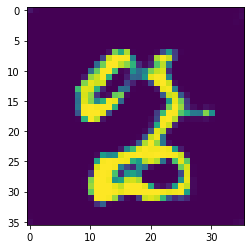

1853it [01:31, 17.55it/s]


 EPOCH 0 iter 1850 
 g_loss 8.013158798217773 
 d_loss 0.05425085872411728 



1875it [01:32, 20.24it/s]
0it [00:00, ?it/s]

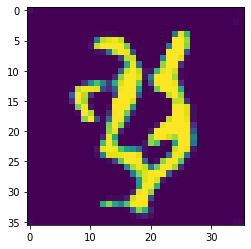

4it [00:00, 13.67it/s]


 EPOCH 1 iter 1875 
 g_loss 6.526035308837891 
 d_loss 0.0957988053560257 



48it [00:02, 21.17it/s]

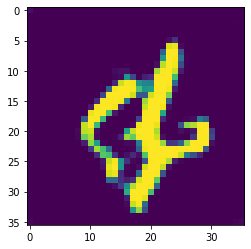

54it [00:02, 17.94it/s]


 EPOCH 1 iter 1925 
 g_loss 11.535425186157227 
 d_loss 3.1693532466888428 



99it [00:04, 21.14it/s]

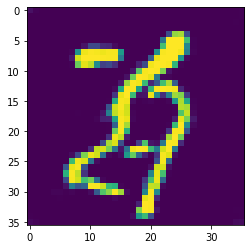

105it [00:05, 15.97it/s]


 EPOCH 1 iter 1975 
 g_loss 5.919891357421875 
 d_loss 0.07326627522706985 



150it [00:07, 21.17it/s]

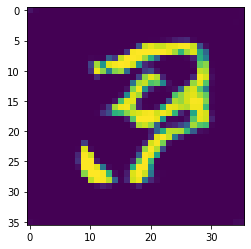

153it [00:07, 17.04it/s]


 EPOCH 1 iter 2025 
 g_loss 5.65902853012085 
 d_loss 0.054741885513067245 



198it [00:09, 21.04it/s]

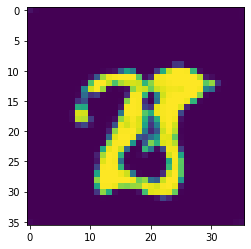

204it [00:10, 17.99it/s]


 EPOCH 1 iter 2075 
 g_loss 7.249373435974121 
 d_loss 0.032224394381046295 



249it [00:12, 21.26it/s]

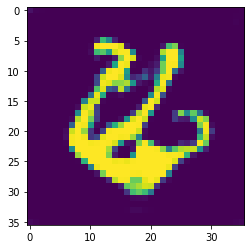

255it [00:12, 18.12it/s]


 EPOCH 1 iter 2125 
 g_loss 8.241082191467285 
 d_loss 0.07517807185649872 



300it [00:14, 21.27it/s]

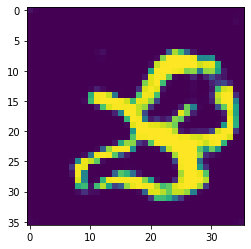

303it [00:15, 16.76it/s]


 EPOCH 1 iter 2175 
 g_loss 7.967527389526367 
 d_loss 0.007206087466329336 



348it [00:17, 21.16it/s]

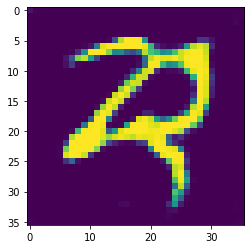

353it [00:17, 17.54it/s]


 EPOCH 1 iter 2225 
 g_loss 9.9469633102417 
 d_loss 0.06686804443597794 



398it [00:19, 21.21it/s]

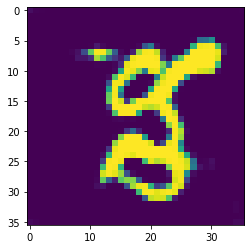

404it [00:20, 18.18it/s]


 EPOCH 1 iter 2275 
 g_loss 6.658285140991211 
 d_loss 0.05046037212014198 



449it [00:22, 21.10it/s]

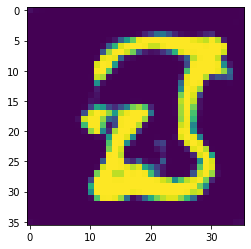

455it [00:22, 17.92it/s]


 EPOCH 1 iter 2325 
 g_loss 7.216248035430908 
 d_loss 0.04012111946940422 



500it [00:24, 21.12it/s]

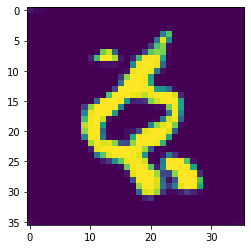

503it [00:25, 16.64it/s]


 EPOCH 1 iter 2375 
 g_loss 9.494138717651367 
 d_loss 0.24840490520000458 



548it [00:27, 21.03it/s]

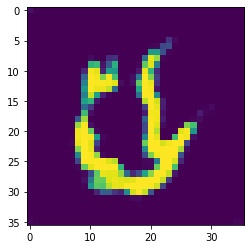

554it [00:27, 17.99it/s]


 EPOCH 1 iter 2425 
 g_loss 7.764039516448975 
 d_loss 0.5715651512145996 



599it [00:29, 21.09it/s]

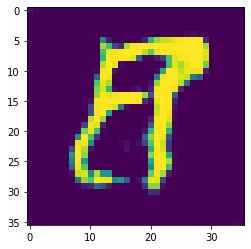

605it [00:30, 17.93it/s]


 EPOCH 1 iter 2475 
 g_loss 7.130939483642578 
 d_loss 0.021731382235884666 



650it [00:32, 21.15it/s]

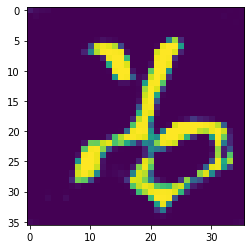

653it [00:32, 16.83it/s]


 EPOCH 1 iter 2525 
 g_loss 6.726695537567139 
 d_loss 0.005423286929726601 



698it [00:34, 21.03it/s]

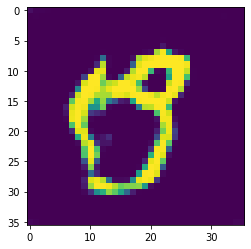

704it [00:35, 17.90it/s]


 EPOCH 1 iter 2575 
 g_loss 5.944116592407227 
 d_loss 0.07243748009204865 



749it [00:37, 21.12it/s]

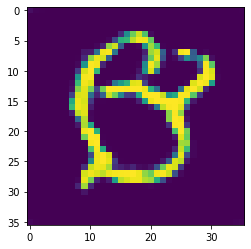

755it [00:37, 17.92it/s]


 EPOCH 1 iter 2625 
 g_loss 5.079370498657227 
 d_loss 0.013978143222630024 



800it [00:39, 21.19it/s]

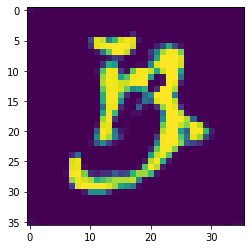

803it [00:40, 14.98it/s]


 EPOCH 1 iter 2675 
 g_loss 3.653437376022339 
 d_loss 0.11323516070842743 



848it [00:42, 21.11it/s]

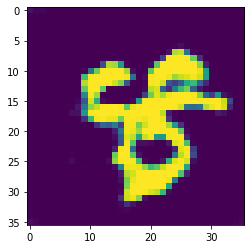

854it [00:42, 17.93it/s]


 EPOCH 1 iter 2725 
 g_loss 6.977873802185059 
 d_loss 0.0327969491481781 



899it [00:44, 21.10it/s]

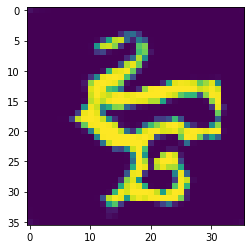

905it [00:45, 18.15it/s]


 EPOCH 1 iter 2775 
 g_loss 6.0479326248168945 
 d_loss 0.012958799488842487 



950it [00:47, 21.16it/s]

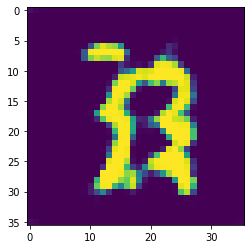

953it [00:47, 16.86it/s]


 EPOCH 1 iter 2825 
 g_loss 6.167708396911621 
 d_loss 0.05630725622177124 



998it [00:49, 21.12it/s]

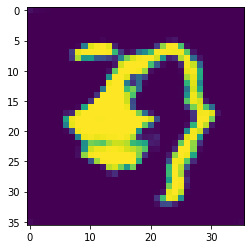

1003it [00:50, 17.63it/s]


 EPOCH 1 iter 2875 
 g_loss 5.158771991729736 
 d_loss 0.028234578669071198 



1048it [00:52, 21.15it/s]

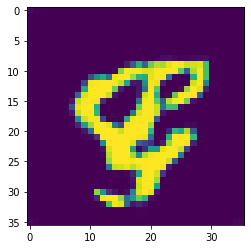

1054it [00:52, 17.99it/s]


 EPOCH 1 iter 2925 
 g_loss 6.344329833984375 
 d_loss 0.0284122284501791 



1099it [00:54, 21.11it/s]

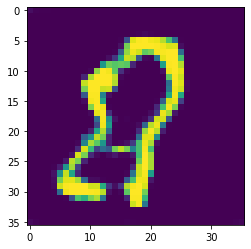

1105it [00:55, 18.03it/s]


 EPOCH 1 iter 2975 
 g_loss 4.110097885131836 
 d_loss 0.25181177258491516 



1150it [00:57, 21.11it/s]

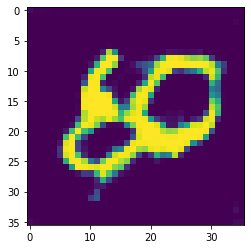

1153it [00:57, 16.91it/s]


 EPOCH 1 iter 3025 
 g_loss 5.614415168762207 
 d_loss 0.23063141107559204 



1198it [00:59, 20.98it/s]

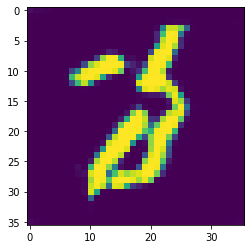

1204it [01:00, 17.93it/s]


 EPOCH 1 iter 3075 
 g_loss 7.305354118347168 
 d_loss 0.003753590863198042 



1249it [01:02, 21.17it/s]

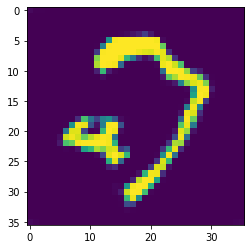

1255it [01:02, 18.10it/s]


 EPOCH 1 iter 3125 
 g_loss 6.8192138671875 
 d_loss 0.07253581285476685 



1300it [01:04, 21.14it/s]

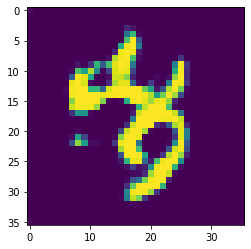

1303it [01:04, 16.91it/s]


 EPOCH 1 iter 3175 
 g_loss 5.728392601013184 
 d_loss 0.041610799729824066 



1348it [01:07, 21.09it/s]

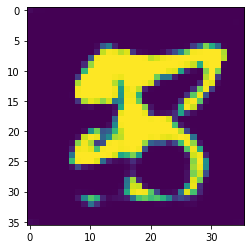

1354it [01:07, 17.96it/s]


 EPOCH 1 iter 3225 
 g_loss 8.331815719604492 
 d_loss 0.016038712114095688 



1399it [01:09, 21.09it/s]

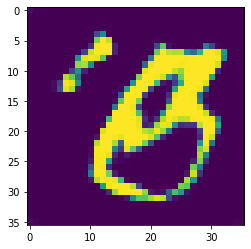

1405it [01:10, 18.08it/s]


 EPOCH 1 iter 3275 
 g_loss 6.71422004699707 
 d_loss 0.0060965316370129585 



1450it [01:12, 21.15it/s]

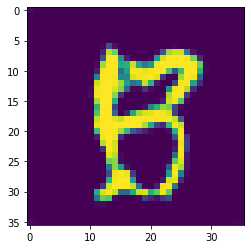

1453it [01:12, 14.83it/s]


 EPOCH 1 iter 3325 
 g_loss 9.278036117553711 
 d_loss 0.00617351196706295 



1498it [01:14, 21.07it/s]

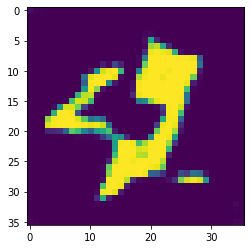

1504it [01:15, 18.01it/s]


 EPOCH 1 iter 3375 
 g_loss 7.182977676391602 
 d_loss 0.008364259265363216 



1549it [01:17, 21.14it/s]

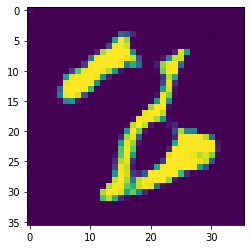

1555it [01:17, 18.06it/s]


 EPOCH 1 iter 3425 
 g_loss 6.574875831604004 
 d_loss 0.0037840665318071842 



1600it [01:19, 21.14it/s]

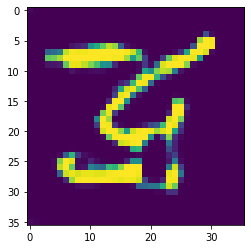

1603it [01:19, 16.99it/s]


 EPOCH 1 iter 3475 
 g_loss 6.364955902099609 
 d_loss 0.32670778036117554 



1648it [01:22, 21.01it/s]

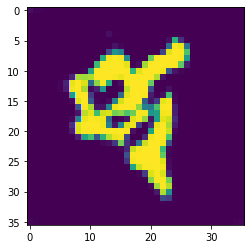

1653it [01:22, 17.39it/s]


 EPOCH 1 iter 3525 
 g_loss 5.6639723777771 
 d_loss 0.0834110900759697 



1698it [01:24, 21.06it/s]

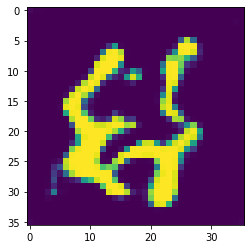

1704it [01:25, 18.02it/s]


 EPOCH 1 iter 3575 
 g_loss 8.530878067016602 
 d_loss 0.006826681550592184 



1749it [01:27, 20.97it/s]

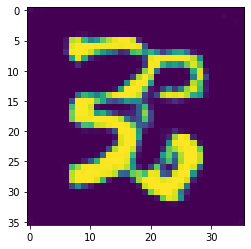

1755it [01:27, 18.02it/s]


 EPOCH 1 iter 3625 
 g_loss 6.752435684204102 
 d_loss 0.08231157064437866 



1800it [01:29, 21.08it/s]

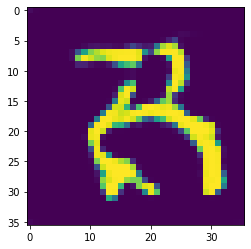

1803it [01:29, 16.91it/s]


 EPOCH 1 iter 3675 
 g_loss 10.570749282836914 
 d_loss 0.12076424807310104 



1848it [01:32, 21.13it/s]

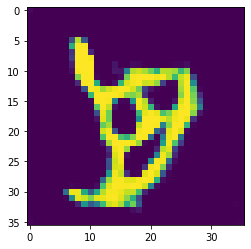

1853it [01:32, 17.66it/s]


 EPOCH 1 iter 3725 
 g_loss 8.168145179748535 
 d_loss 0.012442640960216522 



1875it [01:33, 20.03it/s]
100%|██████████| 2/2 [03:07<00:00, 93.81s/it]


In [15]:
ns1 = 12
ns2 = 12

j = 0
for epoch in trange(EPOCHS):
	for i, data in tqdm(enumerate(trainloader)):

		images = data[0].to(DEVICE)

		# train discriminator
		discriminator.zero_grad()

		d_out_real = discriminator(images)
		d_loss_real = bce(d_out_real, torch.ones(d_out_real.shape[0], 1).to(DEVICE))
		d_loss_real.backward()
		d_optim.step()

		discriminator.zero_grad()

		noise1 = torch.randn(BATCH, 1, ns1, ns2).to(DEVICE)
		g_out_fake = generator(noise1).detach()
		d_out_fake = discriminator(g_out_fake)
		d_loss_fake = bce(d_out_fake, torch.zeros(d_out_fake.shape[0], 1).to(DEVICE))
		d_loss_fake.backward()
		d_optim.step()

		d_loss_avg = (d_loss_real + d_loss_fake) / 2
		# d_loss_avg.backward()
		d_losses.append(d_loss_avg.item())
		
		# train generator
		generator.zero_grad()

		noise2 = torch.randn(BATCH, 1, ns1, ns2).to(DEVICE)
		g_out1 = generator(noise2)
		d_out1 = discriminator(g_out1)
		t_loss1 = bce(d_out1, torch.ones(d_out1.shape[0], 1).to(DEVICE))

		t_loss1.backward()
		g_optim.step()

		g_losses.append(t_loss1.item())

		if i % 50 == 0:
			imshow(test_render(generator))
			show()
			print(
					'\n',
					'EPOCH', epoch, 'iter', j,
					'\n',
					'g_loss', g_losses[len(g_losses) - 1],
					'\n',
					'd_loss', d_losses[len(d_losses) - 1],
					'\n',
			)

		j += 1

			


In [16]:
print(g_losses[0])
print(d_losses[1])
print(g_losses[len(g_losses) - 1])
print(d_losses[len(d_losses) - 1])

0.3116801977157593
0.9832000136375427
7.709266662597656
0.1406337320804596


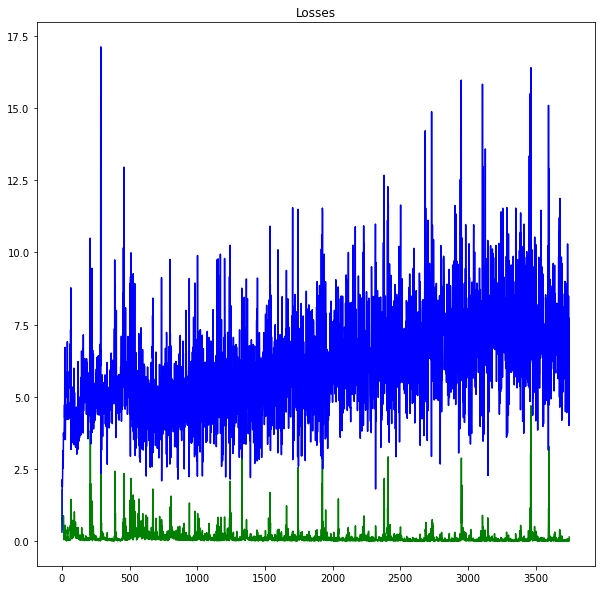

In [17]:
figsize(10,10)
plt.plot(range(len(d_losses)), d_losses, 'g', label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, 'b', label='Generator Loss')
plt.title('Losses')
plt.show()

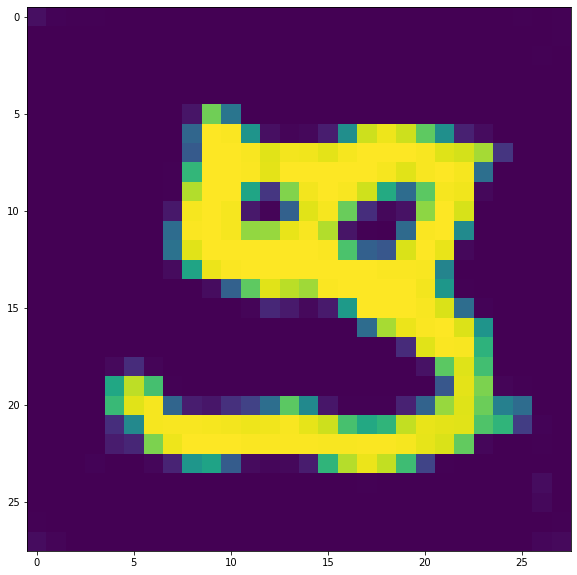

In [18]:
n1 = torch.randn(BATCH, 1, ns1, ns2).to(DEVICE)
out = generator(n1)
imshow(out[0].reshape(28, 28).cpu().detach())